Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Executing eagerly : True
Shape of Encoded Text (5445609,)
Total Sequences : 45380
[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12  0
  1  1 31 73 70 68  1 61 56 64 73 60 74 75  1 58 73 60 56 75 76 73 60 74
  1 78 60  1 59 60 74 64 73 60  1 64 69 58 73 60 56 74 60  8  0  1  1 45
 63 56 75  1 75 63 60 73 60 57 80  1 57 60 56 76 75 80  5 74  1 73 70 74
 60  1 68 64 62 63 75  1 69 60 77 60 73  1 59 64 60  8  0  1  1 27 76 75]

                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12  0  1
  1 31 73 70 68  1 61 56 64 73 60 74 75  1 58 73 60 56 75 76 73 60 74  1
 78 60  1 59 60 74 64 73 60  1 64 69 58 73 60 56 74 60  8  0  1  1 45 63
 56 75  1 75 63 60 73 60 57 80  1 57 60 56 76 75 80  5 74  1 73 70 74 60
  1 68 6

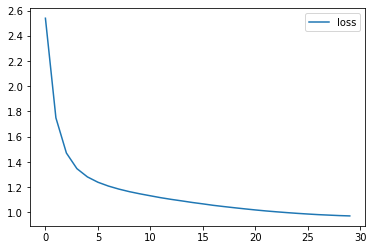

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GRU
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')
print(f'Executing eagerly : {tf.executing_eagerly()}')

text = open('/content/drive/MyDrive/Colab Notebooks/Datasets/shakespeare.txt', 'r').read()
vocab = sorted(set(text))

char_to_index = {char: index for index, char in enumerate(vocab)}
index_to_char = np.array(vocab)
encoded_text = np.array([char_to_index[c] for c in text])
print(f'Shape of Encoded Text {encoded_text.shape}')

seq_length = 120
total_seq = len(encoded_text) // seq_length
print(f"Total Sequences : {total_seq}")

char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)


def create_seq(seq):
    input_text = seq[:-1]
    output_text = seq[1:]
    return input_text, output_text


dataset = sequences.map(create_seq)

for input_txt, output_txt in dataset.take(1):
    print(input_txt.numpy())
    print(''.join(index_to_char[input_txt.numpy()]))
    print('\n')
    print(output_txt.numpy())
    print(''.join(index_to_char[output_txt.numpy()]))

batch_size = 128
buffer_size = 10000
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

vocab_size = len(vocab)
embed_size = 64
rnn_neurons = 1024


def sparse_cat_loss(y_true, y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)


model = Sequential()
model.add(Embedding(vocab_size, embed_size, batch_input_shape=[batch_size, None]))
model.add(GRU(rnn_neurons, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'))
# Final Dense Layer to Predict
model.add(Dense(vocab_size))
model.compile(optimizer='adam', loss=sparse_cat_loss)
model.summary()

early_stop = EarlyStopping(monitor="loss", patience=2)
model.fit(dataset, epochs=30, callbacks=[early_stop])
model.save('shakespeare.h5')
df = pd.DataFrame(model.history.history)
df.plot()
